# Single point analysis of least-cost paths

Here we pick a single point, somewhere in the world, and find the least-cost path to all other points.
It is then visualised, so we can ensure things are making sense.

Most of the time, we'd want to just get the cost of all paths to a point, using the `get_dist_from_point` function, but here we just look at how the algorithm works for a single point.

In [1]:
import meshio
import numpy as np
from multiprocessing import Pool
import time

from LECMesh import LECMesh

In [2]:
infile = "earth/data/globe.vtk"

mesh = meshio.read(infile)

In [3]:
starting_point = 121831  # Pick a point from the mesh
near_point = 221722     # Pick another point, which is relatively close to the starting_point, just for testing

## Using the LECMesh object

Here we can construct an LECMesh object, which contains all the code needed for running the analysis

In [4]:
lm = LECMesh(mesh, max_fuel = 2500)

In [5]:
lm.travel_cost_function(starting_point, near_point)  # Test the travel_cost function between two points

428

In [6]:
lm.dist_func(starting_point, near_point)  # Test the distance function between two points

28621

### Change the functions

We can override the default functions of the LECMesh when we create it:

In [7]:
# Here is a new travel cost function, and it *only* uses elevation as a cost measure.
def elevation_only(current, _next):
    # Only take into account elevation changes for costs
    if current == _next:
        return 0
    return int(abs(mesh.point_data['Z'][current] - mesh.point_data['Z'][_next]))

In [8]:
lm_ele = LECMesh(mesh, max_fuel = 2500, travel_cost_function = elevation_only)

In [9]:
lm_ele.travel_cost_function(starting_point, near_point)  # Test the travel_cost function between two points

314

In [10]:
lm_ele.dist_func(starting_point, near_point)  # Test the distance function between two points

28621

Note that the distance is the same, but the cost is diffent now, since the cost is now *only* the change in elevation:

In [31]:
print("Starting point elevation: ", mesh.point_data['Z'][starting_point])
print("Nearby point elevation:   ", mesh.point_data['Z'][near_point])
print("Change in elevation:      ", mesh.point_data['Z'][starting_point] - mesh.point_data['Z'][near_point])

Starting point elevation:  291.0
Nearby point elevation:    605.0
Change in elevation:       -314.0


# Computing the least-cost paths

Going back to our original `lm` LECMesh object, we can call the `cost_search` function on the `starting_point`, which shows all the paths starting at that point

In [12]:
# Do the least-cost path calculations, and get back the data
#came_from, cost_so_far = cost_search(mesh, starting_point, travel_cost_function = travel_cost, max_distance = max_distance)
came_from, cost_so_far, dist_so_far = lm.cost_search(starting_point)

Now let's see the data structures that come out of that function

### came_from
`came_from` is a dictionary, where the keys are point IDs, and the value is the point ID of the point it came_from.

In [13]:
# Show some of the came_from data structure
count = 0
num_points_to_show = 80
for point, preceeding_point in came_from.items():
    print(str(point) + "\tcame from\t" + str(preceeding_point))
    if count > num_points_to_show:
        break
    count +=1

591887	came from	221719
591888	came from	555519
591889	came from	555515
34834	came from	555573
591892	came from	45577
288806	came from	96820
288808	came from	230111
135219	came from	555463
135220	came from	477058
135221	came from	314188
135222	came from	477062
135223	came from	477057
135224	came from	555459
135225	came from	555513
135226	came from	388553
135227	came from	555515
135228	came from	555469
135230	came from	176706
135231	came from	477095
135232	came from	388523
135234	came from	388486
135244	came from	555566
135245	came from	493114
388513	came from	12406
135272	came from	555522
135273	came from	555509
135275	came from	419119
12403	came from	388496
12404	came from	208162
12405	came from	221708
12406	came from	273721
413856	came from	619550
164029	came from	388521
477081	came from	314159
41155	came from	254251
35012	came from	619125
35013	came from	591779
555528	came from	121830
35015	came from	493118
221719	came from	24990
172249	came from	477061
172251	came from	208159
16612

You can see above that point `66772` "came_from" `None`, since it was the initial point. 

This also means you can pick a point, and follow it back until you reach the starting point, AKA, when the `came_from` value is `None`.
In this case, we'll pick a point from the end of the list of points using: `list(came_from.keys())[-1]`

In [14]:
point = came_from[list(came_from.keys())[-1]]  # choose a start point

In [15]:
# follow a single path back to the origin point
current_point = point
while current_point:   # while point is not None
    print(str(current_point), end="")
    
    # Update the current point to follow the came_from
    current_point = came_from[current_point]
    
    if current_point:
        print(" -> ", end="")

388507 -> 477090 -> 388508 -> 208162 -> 58542 -> 330050 -> 121846 -> 555579 -> 493119 -> 388545 -> 388561 -> 221732 -> 626456 -> 303661 -> 388500 -> 121831

### cost_so_far

`cost_so_far` is also a dictionary, where the keys are point IDs, and the value is total cost it has taken to reach that point, from the starting point

In [16]:
# the cost to get from the starting point to the point we picked
print(cost_so_far[point])

2196


In [17]:
# Show the progressive cost of going from a point to the starting point
current_point = point
while current_point:   # while point is not None
    print(str(cost_so_far[current_point]), end="")
    current_point = came_from[current_point]
    if current_point:
        print(" -> ", end="")

2196 -> 2054 -> 1928 -> 1769 -> 1652 -> 1527 -> 1389 -> 1268 -> 1135 -> 973 -> 842 -> 694 -> 534 -> 350 -> 219 -> 0

### dist_so_far

`dist_so_far` is the same structure as `cost_so_far`, but it shows the length of a path up to that point.

In [18]:
print(dist_so_far[point])

435730


In [19]:
# Show the progressive distance of going from a point to the starting point
current_point = point
while current_point:   # while point is not None
    print(str(dist_so_far[current_point]), end="")
    current_point = came_from[current_point]
    if current_point:
        print(" -> ", end="")

435730 -> 407132 -> 378503 -> 349923 -> 321118 -> 292298 -> 263488 -> 234599 -> 205711 -> 176877 -> 147986 -> 119087 -> 90177 -> 61361 -> 32454 -> 0

We can also find the longest path possible with the given max_fuel

In [29]:
print("Longest path: {:.3f} km".format(max(dist_so_far.values())/1000))

Longest path: 547.771 km


## Show a map of all shortest paths

Since all paths have to lead back to the starting point, we can map out each of their paths by finding edge nodes, and then following the `came_from` paths back to the starting point.

In [20]:
# Find all the nodes that are at the edge of the tree
edge_nodes = []

for k in came_from.keys():             # For all the points we've visited,
    if k not in came_from.values():    # Find all the points that haven't been 'came_from'
        edge_nodes.append(k)
        
print(edge_nodes)

[591887, 591889, 591892, 135228, 135230, 135244, 135272, 135273, 135275, 12405, 41155, 35012, 172249, 172251, 166126, 166127, 43257, 325924, 325926, 325927, 325942, 325943, 330042, 330049, 330053, 555533, 24991, 555421, 25012, 555448, 555453, 555454, 555455, 555462, 555476, 555477, 388516, 146854, 555505, 146857, 555512, 555517, 555521, 555523, 555525, 555526, 555527, 45578, 221710, 96783, 96786, 221721, 146843, 221725, 221726, 555561, 555582, 176703, 176707, 555590, 555592, 303692, 303695, 555625, 619117, 555631, 555634, 619124, 29303, 266876, 266877, 266882, 555563, 150214, 230110, 230113, 146850, 314156, 314157, 241459, 314170, 330026, 24987, 314189, 314216, 80756, 80757, 33657, 555498, 330029, 96816, 328644, 619112, 555511, 121817, 121825, 121827, 121828, 121829, 121839, 121841, 121857, 121859, 121862, 121863, 121865, 619548, 121905, 555530, 459855, 96782, 96808, 591772, 238731, 238732, 199826, 359576, 7321, 179378, 183478, 555562, 101580, 101582, 72919, 72928, 221740, 208141, 3036

In [21]:
# For each edge node, follow the path back to the starting point, and keep track of the points and costs along the way
paths = []
costs = []
dists = []
for p in edge_nodes:
    point = p
    cost = 0
    new_points = []
    new_costs = []
    while point:
        new_points.append(mesh.points[point])  # note, the points are being pulled from the VTK, so we get all their info
        new_costs.append(cost_so_far[point])
        point = came_from[point]

    new_points = np.array(new_points)
    new_costs  = np.array(new_costs)
    paths.append(new_points)
    costs.append(new_costs)

In [23]:
total_dist = 0
for k in came_from.keys():             # For all the points we've visited,
    if k not in came_from.values():    # Find all the points that haven't been 'came_from'
        total_dist += dist_so_far[k]
print(total_dist)

82647929


<IPython.core.display.Javascript object>


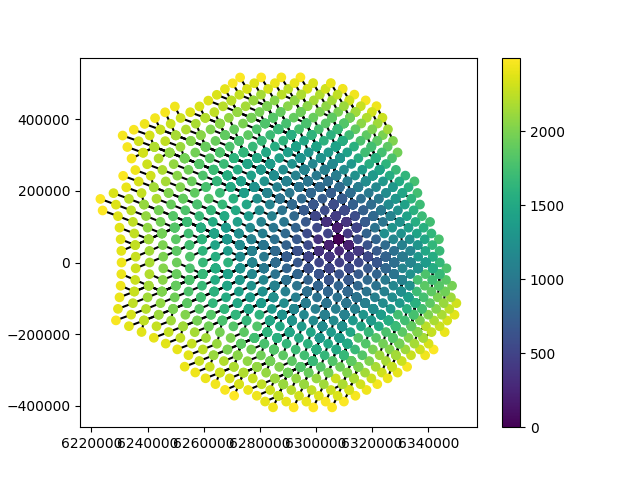

In [26]:
# Visualise all the paths back to the starting point, with colours showing the cost along the way

%matplotlib notebook
import matplotlib.pyplot as plt

norm = plt.Normalize(0, max_cost)
for p, c in zip(paths, costs):    
    plt.plot(p[:,0], p[:,1], c='k', zorder=0)
    plt.scatter(p[:,0], p[:,1], c=c, norm=norm, zorder=1)
    
plt.colorbar()

<IPython.core.display.Javascript object>


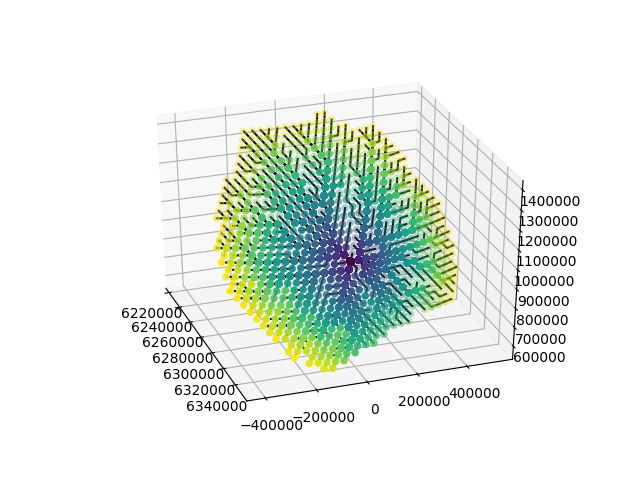

In [25]:
# Visualise all the paths back to the starting point, with colours showing the cost along the way
# In 3D - depending on where you pick on the globae, the 2D can come out all squished. 3D avoids this.
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

norm = plt.Normalize(0, max_cost)
for p, c in zip(paths, costs):    
    ax.plot(p[:,0], p[:,1], p[:,2], c='k', zorder=0)
    ax.scatter(p[:,0], p[:,1], p[:,2], c=c, norm=norm, zorder=1)
    
#plt.colorbar()
#plt.axes().set_aspect('equal', 'datalim')